# Examples for the Path Discovery

Including rewritting of the functions of my previous notebooks. For fine and elegant details refer to my paper.

Entities in this notebook:
------
* $G^S_T$ successor graph
* path condition
* $G^1 + G^2$ graph combination
* clique_graphs (formerly clique decomposition)
* $f$-cut
* upper cut

not yet:
* $G^{S^+}_T$ path equivalent graph
* loop removal


In [1]:
import sys
import logging
logging.basicConfig(format='%(funcName)s:%(levelname)s:%(message)s', level=logging.INFO, stream=sys.stdout)

from helpers import *

In [104]:
# Functions
import networkx as nx

import logging
logger = logging.getLogger()

def successor_graph(T):
    partial_subtrace = T[:]
    G=nx.DiGraph()
    while len(partial_subtrace):
        s_i = partial_subtrace.pop(0)
        for s_j in [ s_i ] + partial_subtrace:
            if s_i in G and s_j in G[s_i]:
                G[s_i][s_j]['weight'] += 1
            else:
                G.add_edge(s_i, s_j, weight=1)
    return G


def G_add_H(G, H):
    J=nx.DiGraph()
    for u, v in G.edges:
        J.add_edge(u, v, weight=G[u][v]["weight"] )
        
    for u, v in H.edges:
        if u in J and v in J[u]:
            J[u][v]["weight"] += H[u][v]["weight"]
        else:
            J.add_edge(u, v, weight=H[u][v]["weight"] )
    return J
        
    
def f_cut(f, G):
    H = nx.DiGraph()
    for u, v in G.edges:
        if G[u][v]["weight"] == f:
            H.add_edge(u, v, weight=G[u][v]["weight"])
    return H


def path_condition( G ):

    # 1) InDeg (a_i) = i+1  (starting at 0)

    # Order nodes by inner degree should be 1,2,3,...
    nodes = sorted( G.in_degree() , key=lambda u: u[1], reverse=False)
    naturals = range(1, len(nodes)+1)

    if not all( [in_degree == i for i, (u, in_degree) in zip( naturals , nodes)] ) :
        logger.info("Condition '1) InDegree' not met. %s not a path." % list(G.nodes))
        return False
    
    # 2) Weights must be a constant
    
    E    = list(G.edges())
    u, v = E[0]
    constant_weight = G[u][v]["weight"]

    if not all([ G[u][v]["weight"] == constant_weight for u, v in E ] ):
        logger.info("Condition '2) Weights must be a constant' not met. %s not a path." % list(G.nodes))
        return False
    
    # Conditions are met. It is a path, congratulations mom!
    return True

def clique_graphs( G ):
    CliqueSet = list( nx.algorithms.clique.find_cliques( G.to_undirected() ) )
    
    cGraphs = []
    for CliqueVertices in CliqueSet:
        G_clique = G.copy()

        # remove the nodes not in this clique 
        for node in set(G_clique.nodes).difference( set(CliqueVertices) ):
            G_clique.remove_node(node)   
            
        cGraphs.append(G_clique)
        
    return cGraphs
    

In [8]:
from networkx.drawing.nx_agraph import write_dot
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image
import pygraphviz as pgv

def graph(G, color="#cccccc", filename="simple.png"):


    # [ (u, v, Gs_T[u][v]["weight"]) for u, v in Gs_T.edges]
    # graph( Gs_T )

    # write_dot(Gs_T,'graph.dot')
    # !dot -Tpng graph.dot > graph.png
    # display(Image("graph.png"))




    for u, v in G.edges:
        G[u][v]["label"] = G[u][v]["weight"]
    G.graph['graph']={'rankdir':'TD'}
    G.graph['node']={'shape':'circle'}
    G.graph['edges']={'arrowsize':'1.0'}

    # Gs_T.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curves'}
    # Gs_T.graph['graph'] = {'scale': '5'}

    A = to_agraph(G) 
    A.layout('dot')                                                                 
    A.draw(filename) 
    display(Image(filename))

    # B = pgv.AGraph('graph.dot')  # create a new graph from file
    # B.layout(prog='dot')  # layout with default (neato)
    # B.draw('simple.png')  # draw png
    # display(Image("simple.png"))

    #     pos = nx.circular_layout(G)
    #     plt.rcParams['figure.figsize'] = [10, 6]
    #     plt.subplot(111)

    #     nx.draw_networkx (G, pos, width=1, node_color=color, with_labels=True, connectionstyle='arc3, rad=0.1' )
    #     if with_weigths:
    #         weights = { (str(u), str(v)): G[u][v]['weight'] for u,v in G.edges() }
    #         nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights, connectionstyle='arc3, rad=0.1')
    #     plt.show()
    
def count_successor_pairs( T ):
    
    logger.debug("Extracting pairs for %d elements in T=%s" % ( len(T), T[:20]) ) 
    pairs = []
    partial_subtrace = T[:]
    
    while len(partial_subtrace):
        s_i = partial_subtrace.pop(0)
        pairs += [ (s_i, s_i) ] + [ (s_i, s_j) for s_j in partial_subtrace ]

    logger.debug("Pairs for found = %d" % ( len(pairs) ) ) 
    return pairs

## Successor Graph

Below are the successor graphs of $A=abc$, $B=aabc$.

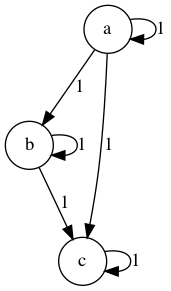

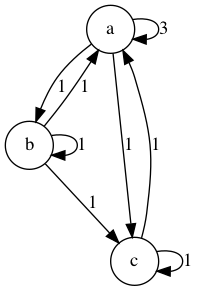

In [78]:
graph( successor_graph(list("abc") ), "successor_graph_path.png")
graph( successor_graph(list("abca")), "successor_graph_abca.png")

## Clique Graphs

In [114]:
def show(Gs):
    for G in Gs:
        graph(G)

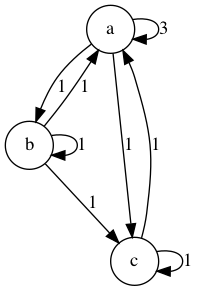

In [140]:
T="abca"
show( clique_graphs( successor_graph(list(T)) )  )

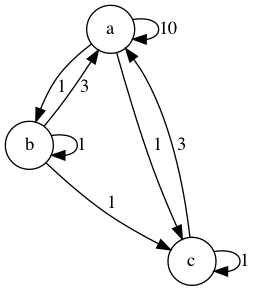

In [117]:
T="abcaaa"
show( clique_graphs( successor_graph(list(T)) )  )

## Loops

The successor graph for $L=pqrpqrpqrpqr=4(pqr)$ is the following:

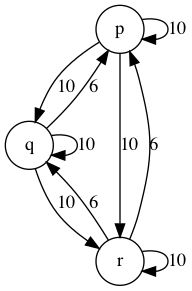

In [90]:
L="pqr"*4
successor_G_L = successor_graph(list(L)) 
graph(successor_G_L, "successor_graph_loop.png")

The graph has weights $w^+=10$ , $w^-=6$, and $r = \sqrt{10 + 6} = 4 $

And the $f$-cuts of $L$ for $f=10$ and $f=6$ are:

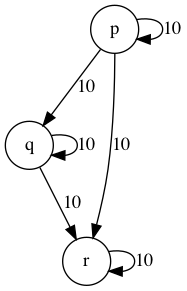

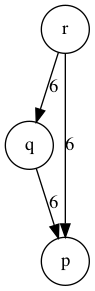

In [92]:
graph( f_cut( 10, successor_G_L ), "upper-cut-L.png" )
graph( f_cut( 6,  successor_G_L ), "lower-cut-L.png" )

The upper-cut of $L$ verifies the path condition:

In [94]:
assert path_condition( f_cut( 10, successor_G_L ) ) == True

## Combining paths

Combine same path several times, $A=aei$, $\sum^{N=2} G^S_A$

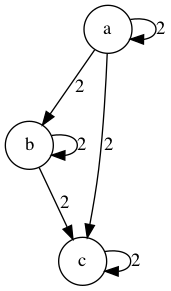

In [95]:
A="abc"
J = G_add_H( successor_graph( list(A) ), successor_graph( list(A) ) )
graph(J)

Path condition holds true, therefore $J$ is a path repeated $r=2$ times.

In [97]:
assert path_condition(J) == True

Combine two disjoint paths $A=aei, B=xyz$ gives a graph with two connected components

$J = G^S_{rA} + G^S_{rB}$ 

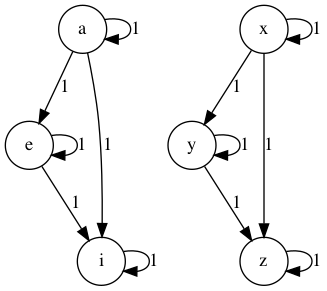

In [98]:
J = G_add_H( successor_graph( list("aei") ), successor_graph( list("xyz") ) )
graph(J)

The path condition for is not be met for the whole $J$

In [107]:
assert path_condition(J) == False

path_condition:INFO:Condition '1) InDegree' not met. ['a', 'e', 'i', 'x', 'y', 'z'] not a path.


But it is true for every clique graph individually.

In [108]:
for G in clique_graphs(J):
    assert path_condition(G) == True

# Combining Loops

Given the loop $L=rA$, the graph resulting by adding $ G^S_{rA}$ with itself several times 

$K = \sum_{}^{ N=2 } G^S_{rA}$ 

is no longer a loop. In the example, the condition $r=\sqrt{w^+ + w^-}$: $\sqrt {6 + 2} = \sqrt 8$ is not an integer number.

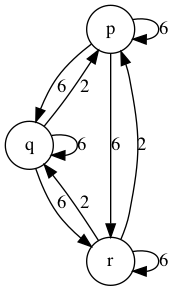

In [102]:
A = "pqr"*2
successor_G_L = successor_graph( list(A) )
K = G_add_H( successor_G_L , successor_G_L )
graph(K)

But, interestingly, the path condition is met for all the upper cuts of $K = \sum_{}^{ N=2 } G^S_{rA}$ 

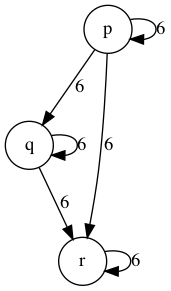

In [112]:
graph( f_cut( 6, K ) )

In [109]:
assert path_condition( f_cut( 6, K ) ) == True

### Full merges

In [ ]:
graph(  successor_graph(list("pqxyxypq")))  

In [ ]:
G=nx.DiGraph()
G.add_edge(1,2)
G[1][2]['weight'] = 1
G[1][2]

## Cases Study

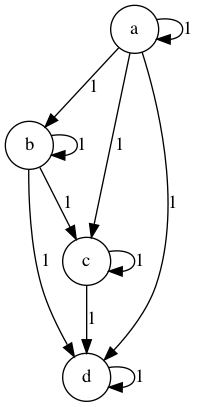

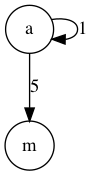

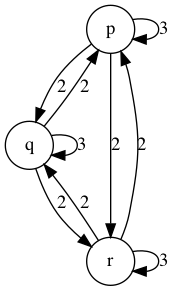

In [139]:
# THIS EXAMPLE SHOULD BE SHOWN IN DETAIL. The f-cuts will trim out (a,m)!

# A path is added. This is a clique.
T="abcd"
sT=successor_graph(list(T))

# This structure is a clique but not a path, nor a loop
Z="pqrrqp"
sZ=successor_graph(list(Z))

G = G_add_H( sT, sZ ) 

# And now a single edge from a
G.add_edge("a", "m", weight=5)

show( clique_graphs(G)  )

## Complexity

Measure execution times of extract successor pairs for traces with length $N=1000, 2000, 3000, 4000, 5000$

In [103]:
%timeit count_successor_pairs( list("a"*1000) )
%timeit count_successor_pairs( list("a"*2000) )
%timeit count_successor_pairs( list("a"*3000) )
%timeit count_successor_pairs( list("a"*4000) )
%timeit count_successor_pairs( list("a"*5000) )

62.4 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
253 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
564 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.01 s ± 5.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.58 s ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# import pygraphviz